# Neural Network Model

import statements

In [1]:
import numpy as np
import pandas as pd
import torch
import json
from torch.utils.data import random_split, Dataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from torch.autograd import Variable

splitting the data

In [2]:
# Load JSON data
with open('restaurant-topic-sentiment.json') as file:
    json_data = json.load(file)

# Convert to DataFrame
df = pd.DataFrame.from_dict(json_data, orient='index')

print(df)

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Convert DataFrame to numpy array
data = df.to_numpy()

# Calculate the size of train and test splits
train_size = int(0.8 * len(data))
test_size = len(data) - train_size

# Split the dataset
train_data, test_data = random_split(data, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Assuming the last column (index -1) is the label 'rating'
        x = self.data[idx, :-1]
        y = self.data[idx, -1]
        return x, y

# Create datasets and dataloaders
train_dataset = CustomDataset(np.array(train_data))
test_dataset = CustomDataset(np.array(test_data))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

                                       pos_food  pos_service  pos_location  \
0x809ae410bb4b79db:0x8e53e91c4a62cfcd  1.166667     0.666667      0.000000   
0x809ae58e5b6f8889:0x997c522d3d5cf906  0.750000     0.250000      0.000000   
0x80852990182f7d55:0xe7374fc8442789f1  0.750000     0.000000      0.000000   
0x8084d0e5f234f735:0x782262f8c6962382  0.000000     0.000000      0.250000   
0x8084d155d59bbe79:0xea9392e201d6ec6f  1.000000     0.125000      0.000000   
...                                         ...          ...           ...   
0x809ae5006006087b:0x8c7adb7c03ebaca9  0.622517     0.344371      0.168874   
0x809ae486e766bf13:0x56fa6eebc6e42ad5  0.868421     0.368421      0.236842   
0x809ae41d3806acef:0x537909d76379614b  1.007576     0.424242      0.272727   
0x809ad0dc95d366e1:0xd01da213a959bf71  1.014085     0.169014      0.214085   
0x809add6b67412841:0x51386482530fe0d9  1.026515     0.329545      0.219697   

                                       pos_clean  pos_price  ne

define our hyperparameters

In [3]:
inputDim = 10
outputDim = 1
learningRate = .0115
epochs = 150

lambda1 = 0 # l1 regularization parameter (sum of weights)
lambda2 = 0 # l2 regularization parameter (sum of square of weights)

defining different models

In [4]:
class NeuralNetwork1(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(NeuralNetwork1, self).__init__()
        self.relu = torch.nn.ReLU() 
        self.layer1 = torch.nn.Linear(inputSize, 20)  # Only hidden layer
        self.output_layer = torch.nn.Linear(20, outputSize)  # Output layer

    def forward(self, x):
        x = self.relu(self.layer1(x))  # Using ReLU activation function
        x = self.output_layer(x)
        return x


In [5]:
class NeuralNetwork2(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(NeuralNetwork2, self).__init__()
        self.relu = torch.nn.ReLU() # activation function
        self.layer1 = torch.nn.Linear(inputSize, 10)  # First hidden layer
        self.layer2 = torch.nn.Linear(10, 10)         # Second hidden layer
        self.output_layer = torch.nn.Linear(10, outputSize)  # Output layer

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output_layer(x)
        return x

In [6]:
class NeuralNetwork3(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(NeuralNetwork3, self).__init__()
        self.relu = torch.nn.ReLU() 
        self.layer1 = torch.nn.Linear(inputSize, 50)  # First hidden layer
        self.layer2 = torch.nn.Linear(50, 50)         # Second hidden layer
        self.layer3 = torch.nn.Linear(50, 50)         # Third hidden layer
        self.output_layer = torch.nn.Linear(50, outputSize)  # Output layer

    def forward(self, x):
        x = torch.relu(self.layer1(x))  # Using ReLU activation function
        x = torch.relu(self.layer2(x))  # Using ReLU activation function
        x = torch.relu(self.layer3(x))  # Using ReLU activation function
        x = self.output_layer(x)
        return x


check for gpu & define our model

In [7]:
# For GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = NeuralNetwork1(inputDim, outputDim).to(device)
torch.save(model, 'nn_model.pt')

define our model training function

In [8]:
def train_model(model: torch.nn.Module, train_loader: DataLoader, learningRate: float, epochs: int, lambda1: float, lambda2: float):
    
    criterion = torch.nn.MSELoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

    mse_history = []

    for epoch in range(epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.float().to(device)
            labels = labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
        
            all_params = torch.cat([x.view(-1) for x in model.parameters()])
            l1_regularization = lambda1 * torch.norm(all_params, 1)
            l2_regularization = lambda2 * torch.norm(all_params, 2)
        
            loss = criterion(outputs.view(-1), labels) + l1_regularization + l2_regularization
            loss.backward()
            optimizer.step()

    # Calculate MSE for this epoch and store it
        with torch.no_grad():
            epoch_losses = []
            for inputs, labels in train_loader:
                inputs = inputs.float().to(device)
                labels = labels.float().to(device)
                outputs = model(inputs)
                epoch_loss = criterion(outputs.view(-1), labels)
                epoch_losses.append(epoch_loss.item())
            mse_history.append(np.mean(epoch_losses))

        #print(f'Epoch [{epoch+1}/{epochs}], Loss: {mse_history[-1]:.4f}')
    
    # print(torch.cat([x.view(-1) for x in model.parameters()]))
    return model, mse_history

In [9]:
# Define our model training function with Huber loss
def train_model_huber(model: torch.nn.Module, train_loader: DataLoader, learningRate: float, epochs: int, lambda1: float, lambda2: float):
    
    criterion = torch.nn.HuberLoss()  # Use Huber loss
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

    mse_history = []

    for epoch in range(epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.float().to(device)
            labels = labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
        
            all_params = torch.cat([x.view(-1) for x in model.parameters()])
            l1_regularization = lambda1 * torch.norm(all_params, 1)
            l2_regularization = lambda2 * torch.norm(all_params, 2)
        
            loss = criterion(outputs.view(-1), labels) + l1_regularization + l2_regularization
            loss.backward()
            optimizer.step()

        # Calculate MSE for this epoch and store it
        with torch.no_grad():
            epoch_losses = []
            for inputs, labels in train_loader:
                inputs = inputs.float().to(device)
                labels = labels.float().to(device)
                outputs = model(inputs)
                epoch_loss = criterion(outputs.view(-1), labels)
                epoch_losses.append(epoch_loss.item())
            mse_history.append(np.mean(epoch_losses))

    return model, mse_history


define our model testing function

In [10]:
# Predict target variable using test data
def test_model(model: torch.nn.Module, test_loader: DataLoader):
    model.eval()
    all_predictions = []
    all_labels = []
    all_inputs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.float().to(device)
            labels = labels.float().to(device)
            outputs = model(inputs).cpu()
            # Clip the outputs to the range 1-5
            clipped_outputs = torch.clamp(outputs, 1, 5).view(-1)
            all_predictions.extend(clipped_outputs.numpy())
            all_labels.extend(labels.cpu().numpy())
            all_inputs.extend(inputs.cpu().numpy())

    return np.array(all_predictions), np.array(all_labels), np.array(all_inputs)


train the model

In [11]:
model, mse_history = train_model(model, train_loader, learningRate, epochs, lambda1, lambda2)

test our model

<Figure size 640x480 with 0 Axes>

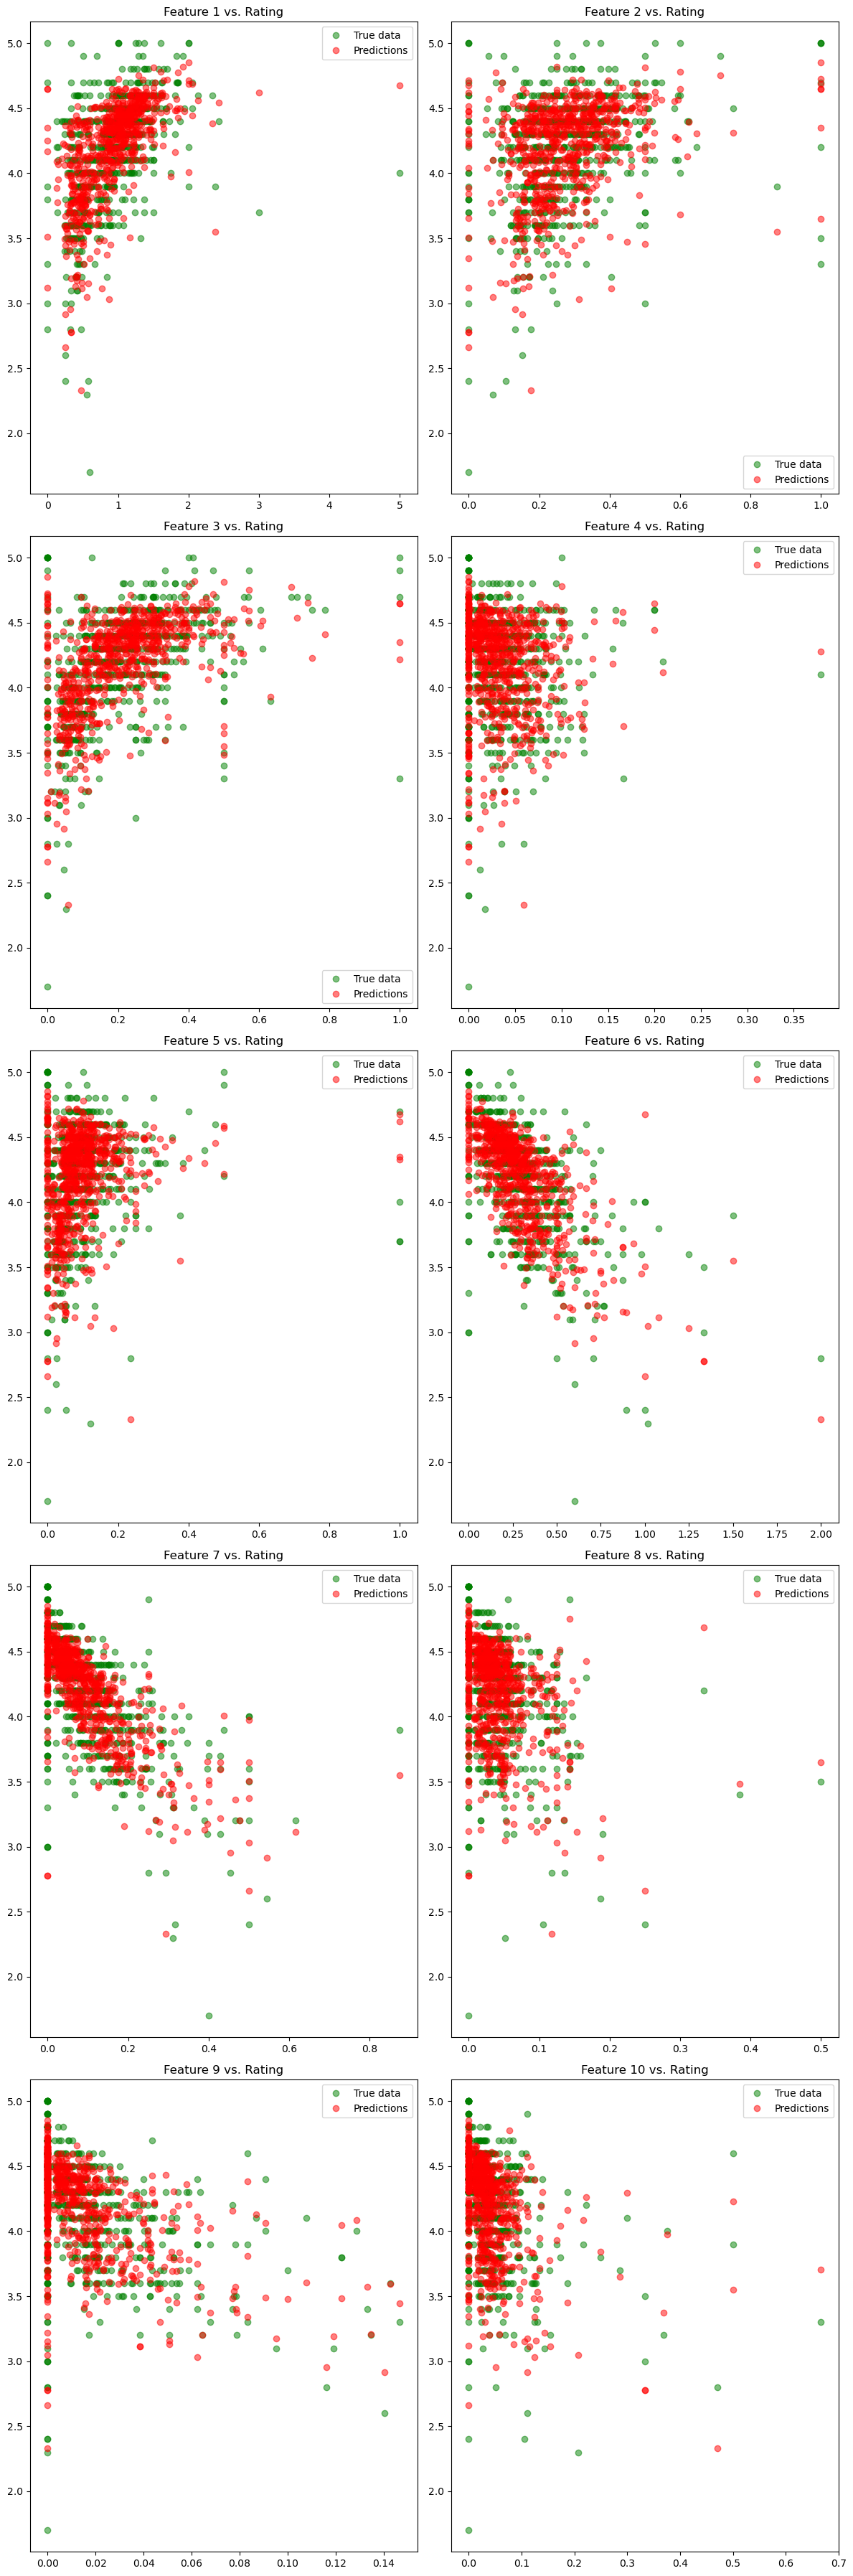

In [12]:
all_predictions, all_labels, all_inputs = test_model(model, test_loader)

plt.clf()
fig, axes = plt.subplots(5, 2, figsize=(12, 36))
axes = axes.flatten()

# Plot model predictions with respect to each attribute
for i in range(10):  # Assuming 10 features
    axes[i].plot(all_inputs[:, i], all_labels, 'go', label='True data', alpha=0.5)
    axes[i].plot(all_inputs[:, i], all_predictions, 'ro', label='Predictions', alpha=0.5)
    axes[i].set_title(f'Feature {i+1} vs. Rating')
    axes[i].legend(loc='best')

plt.tight_layout()
plt.show()

perform some performance calculations

Mean Squared Error: 0.05254121869802475
Root Mean Squared Error: 0.22921870648860931
R-squared: 0.7022555861797369


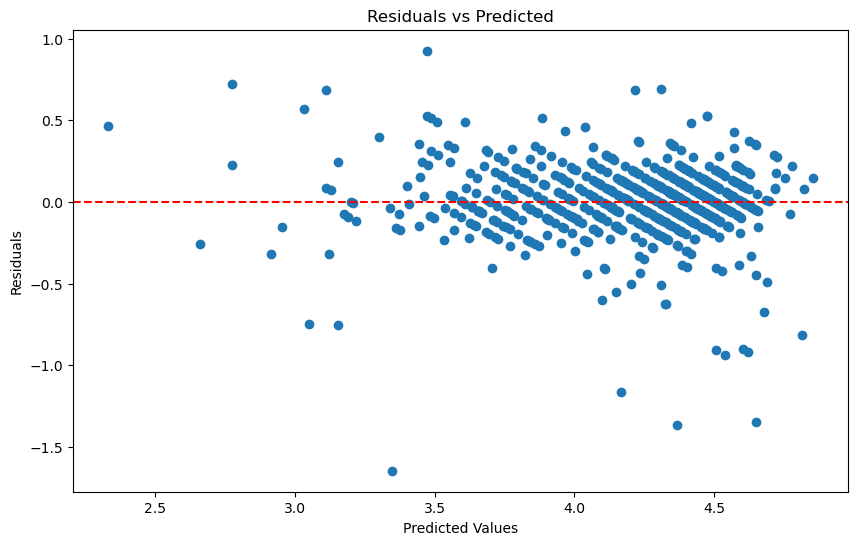

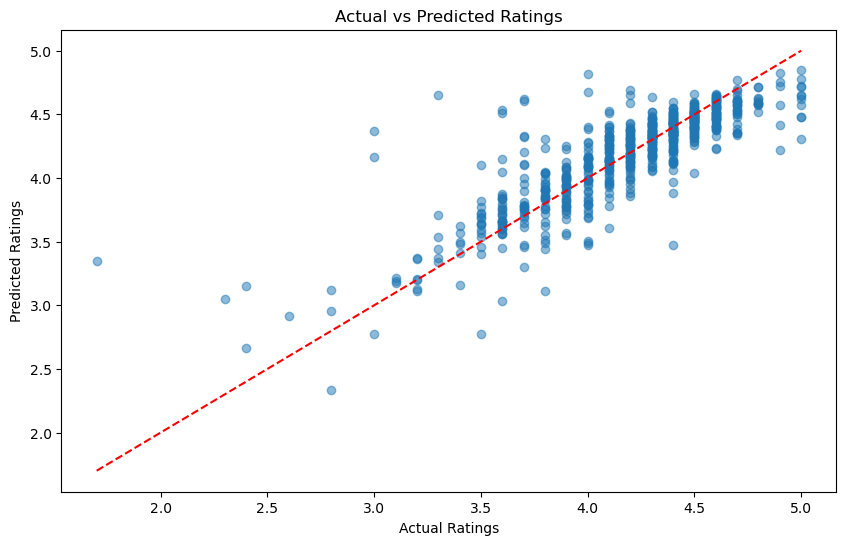

In [13]:
# Calculate metrics
mse = mean_squared_error(all_labels, all_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(all_labels, all_predictions)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

# Residual Plot
plt.figure(figsize=(10, 6))
residuals = all_labels - all_predictions
plt.scatter(all_predictions, residuals)
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Comparison Plot
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_predictions, alpha=0.5)
plt.title('Actual vs Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], 'r--')  # line representing perfect predictions
plt.show()

plot the mse over multiple epochs

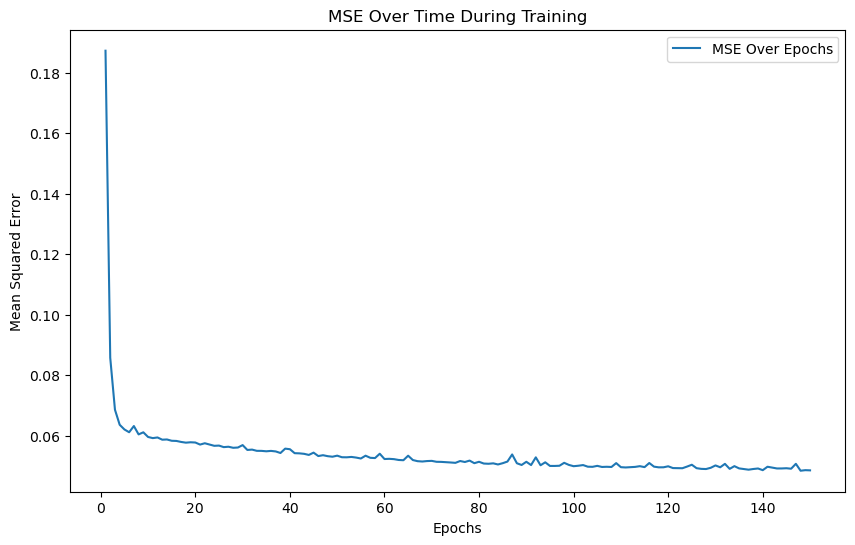

In [14]:
# Plotting the MSE over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), mse_history, label='MSE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('MSE Over Time During Training')
plt.legend()
plt.show()

get the weights

In [15]:
# Extracting weights and biases from each layer
for name, param in model.named_parameters():
    if 'weight' in name:
        print(f'{name}: {param.data.cpu().numpy().flatten()}')
    elif 'bias' in name:
        print(f'{name}: {param.data.cpu().numpy()}')


layer1.weight: [ 0.02887768  0.04506817 -0.24408975 -0.07324934 -0.06859356 -0.2034463
  0.29569003 -0.25987688 -0.2779647  -0.12272096 -0.2593509  -0.32416368
  0.19527464 -0.00457343  0.20713931  0.05982442 -0.22231176 -0.23804307
 -0.12064278  0.16978735  0.20098855  0.24783476 -0.02518773  0.27083367
  0.19833039 -0.17538773 -0.3204443   0.05059057 -0.29231155 -0.12824221
 -0.16438371 -0.11885709  0.22766338  0.3188983  -0.15628152  0.11938097
  0.2105264  -0.1366325  -0.23903799 -0.2329365   0.13488351 -0.23046896
 -0.11272901  0.07197001  0.00177698 -0.00117115 -0.17753877 -0.3399122
  0.03387621  0.16312447  0.50612104  0.28125232  0.32209072  0.17517269
  0.08664731 -0.35340032  0.05322383  0.16178949  0.07168573  0.22300942
  0.37631723  0.3036824   0.46034268 -0.14645223 -0.17516749 -0.3648834
 -0.16681291  0.03018687 -0.49698415  0.11399604 -0.26878616 -0.01584451
  0.11122907 -0.14640024 -0.23606351  0.1798399  -0.12837364 -0.09925748
  0.08768225  0.16131455  0.14899461  0

lets try different activation functions

In [16]:
class NeuralNetworkELU(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(NeuralNetworkELU, self).__init__()
        self.layer1 = torch.nn.Linear(inputSize, 50)
        self.elu = torch.nn.ELU()  # ELU activation function
        self.output_layer = torch.nn.Linear(50, outputSize)

    def forward(self, x):
        x = self.elu(self.layer1(x))
        x = self.output_layer(x)
        return x

class NeuralNetworkLinear(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(NeuralNetworkLinear, self).__init__()
        self.layer1 = torch.nn.Linear(inputSize, 50)
        self.output_layer = torch.nn.Linear(50, outputSize)

    def forward(self, x):
        x = self.layer1(x)  # Linear activation (no activation function)
        x = self.output_layer(x)
        return x

class NeuralNetworkLeakyReLU(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(NeuralNetworkLeakyReLU, self).__init__()
        self.layer1 = torch.nn.Linear(inputSize, 50)
        self.leaky_relu = torch.nn.LeakyReLU(0.01)  # LeakyReLU activation
        self.output_layer = torch.nn.Linear(50, outputSize)

    def forward(self, x):
        x = self.leaky_relu(self.layer1(x))
        x = self.output_layer(x)
        return x

class NeuralNetworkSELU(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(NeuralNetworkSELU, self).__init__()
        self.layer1 = torch.nn.Linear(inputSize, 50)
        self.selu = torch.nn.SELU()  # SELU activation
        self.output_layer = torch.nn.Linear(50, outputSize)

    def forward(self, x):
        x = self.selu(self.layer1(x))
        x = self.output_layer(x)
        return x

class NeuralNetworkSigmoid(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(NeuralNetworkSigmoid, self).__init__()
        self.layer1 = torch.nn.Linear(inputSize, 50)
        self.sigmoid = torch.nn.Sigmoid()  # Sigmoid activation
        self.output_layer = torch.nn.Linear(50, outputSize)

    def forward(self, x):
        x = self.sigmoid(self.layer1(x))
        x = self.output_layer(x)
        return x



train the model again.
note: not all of the activation functions are shown here, as I removed them for their poor performance.

LeakyReLU

Mean Squared Error: 0.05336635932326317
Root Mean Squared Error: 0.23101159930229187
R-squared: 0.6975796382860585


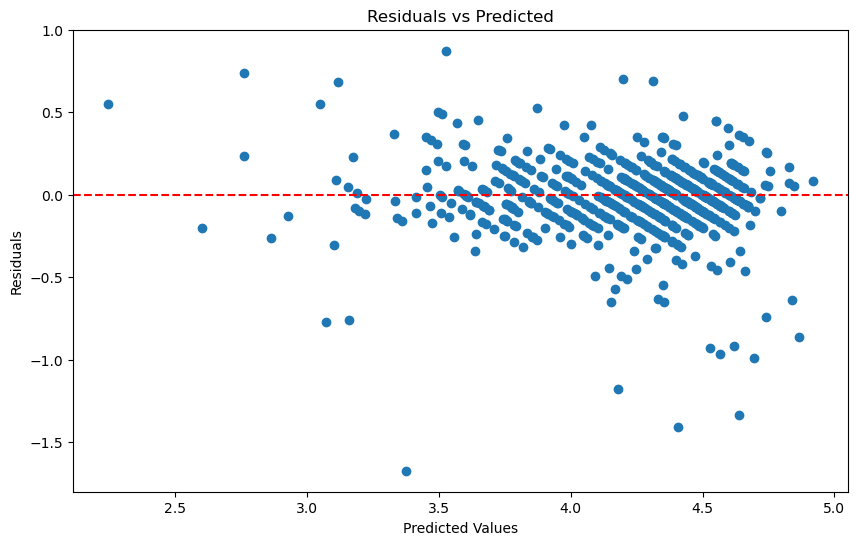

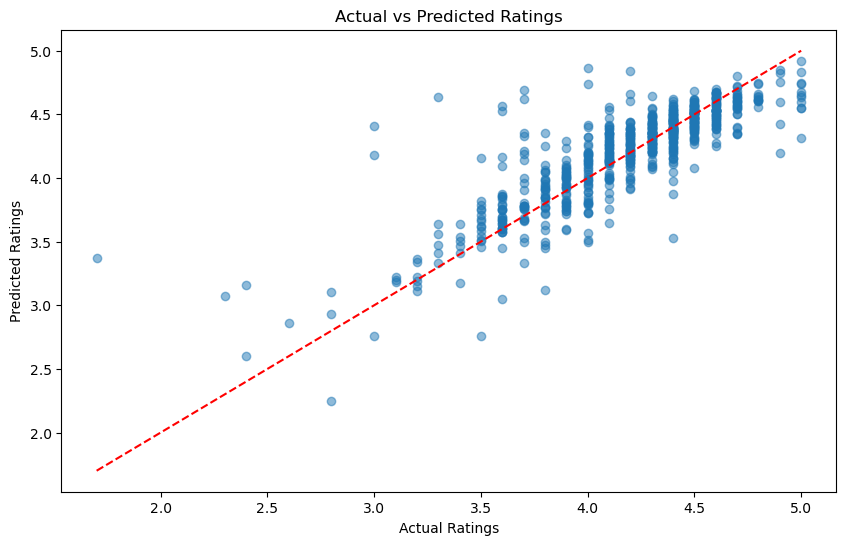

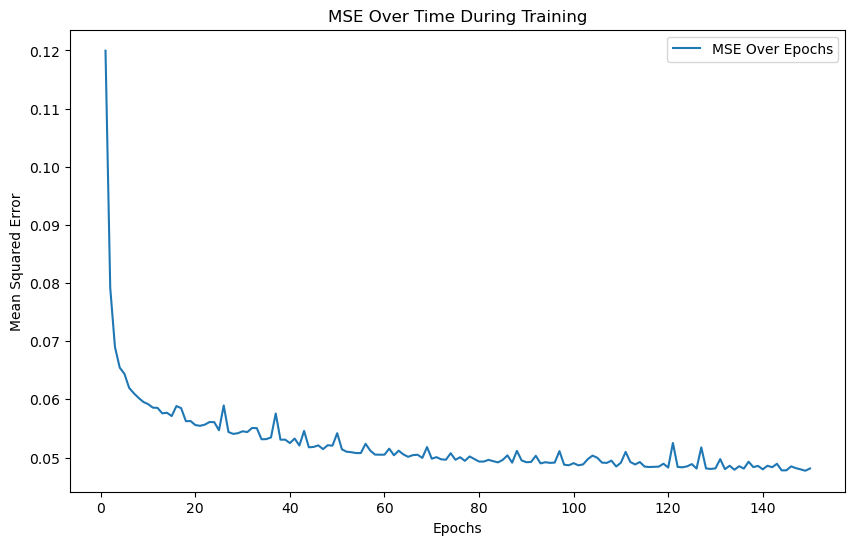

In [17]:
model = NeuralNetworkLeakyReLU(inputDim, outputDim).to(device)
model, mse_history = train_model(model, train_loader, learningRate, epochs, lambda1, lambda2)
all_predictions, all_labels, all_inputs = test_model(model, test_loader)

# Calculate metrics
mse = mean_squared_error(all_labels, all_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(all_labels, all_predictions)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

# Residual Plot
plt.figure(figsize=(10, 6))
residuals = all_labels - all_predictions
plt.scatter(all_predictions, residuals)
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Comparison Plot
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_predictions, alpha=0.5)
plt.title('Actual vs Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], 'r--')  # line representing perfect predictions
plt.show()

# Plotting the MSE over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), mse_history, label='MSE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('MSE Over Time During Training')
plt.legend()
plt.show()

**ELU (best performance)**

Mean Squared Error: 0.058851197361946106
Root Mean Squared Error: 0.24259266257286072
R-squared: 0.6664977465770934


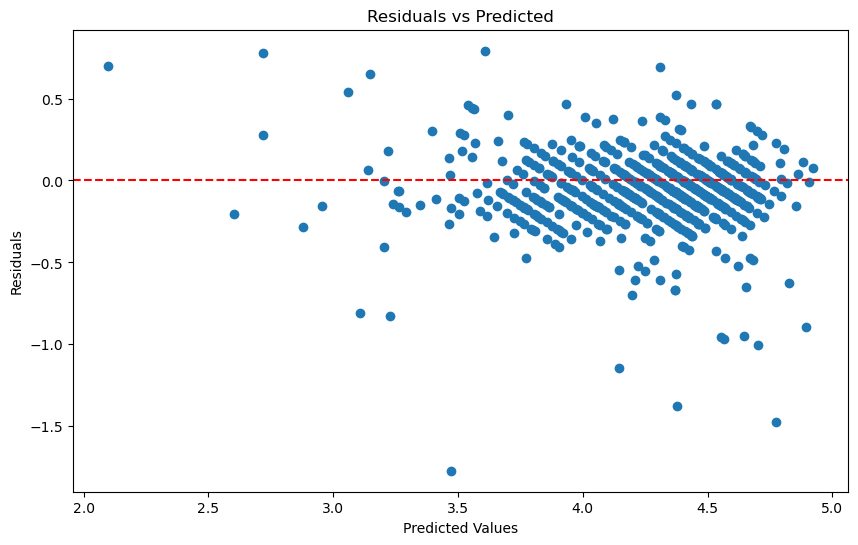

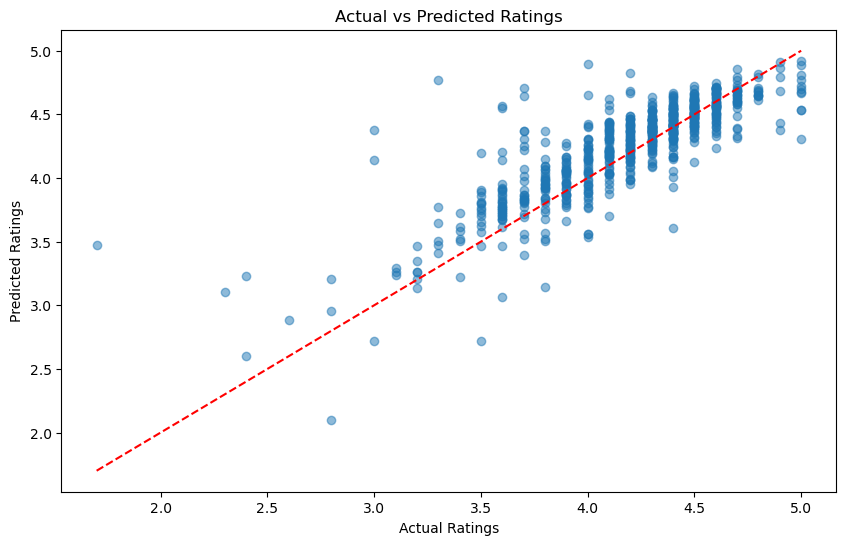

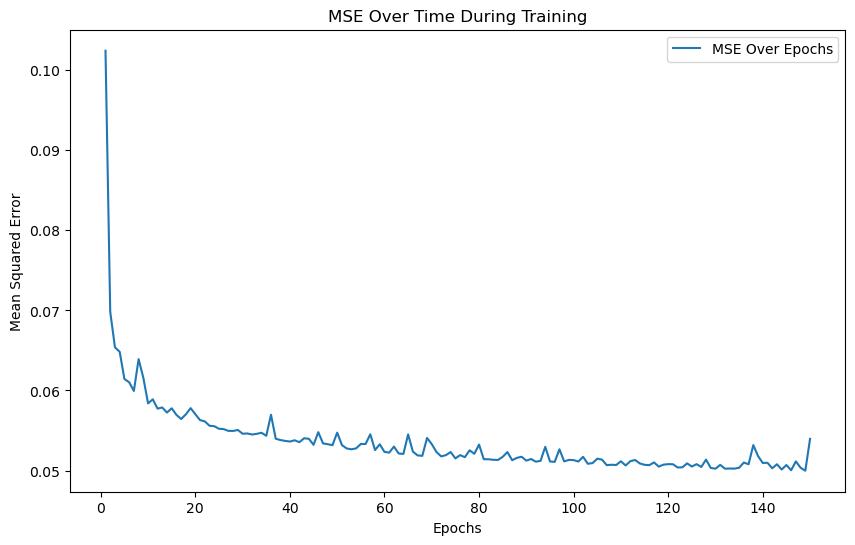

In [18]:
model = NeuralNetworkELU(inputDim, outputDim).to(device)
model, mse_history = train_model(model, train_loader, learningRate, epochs, lambda1, lambda2)
all_predictions, all_labels, all_inputs = test_model(model, test_loader)

# Calculate metrics
mse = mean_squared_error(all_labels, all_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(all_labels, all_predictions)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

# Residual Plot
plt.figure(figsize=(10, 6))
residuals = all_labels - all_predictions
plt.scatter(all_predictions, residuals)
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Comparison Plot
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_predictions, alpha=0.5)
plt.title('Actual vs Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], 'r--')  # line representing perfect predictions
plt.show()

# Plotting the MSE over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), mse_history, label='MSE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('MSE Over Time During Training')
plt.legend()
plt.show()

selu

Mean Squared Error: 0.0531877726316452
Root Mean Squared Error: 0.2306247502565384
R-squared: 0.6985916626729545


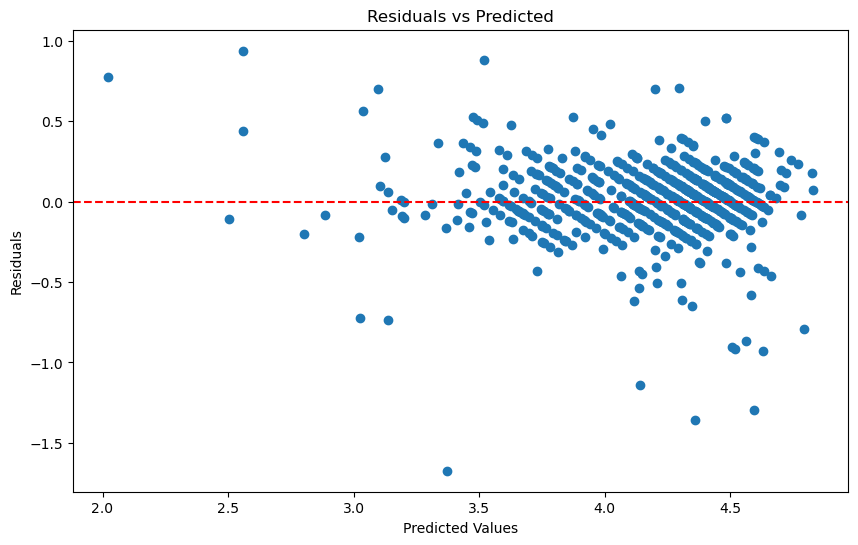

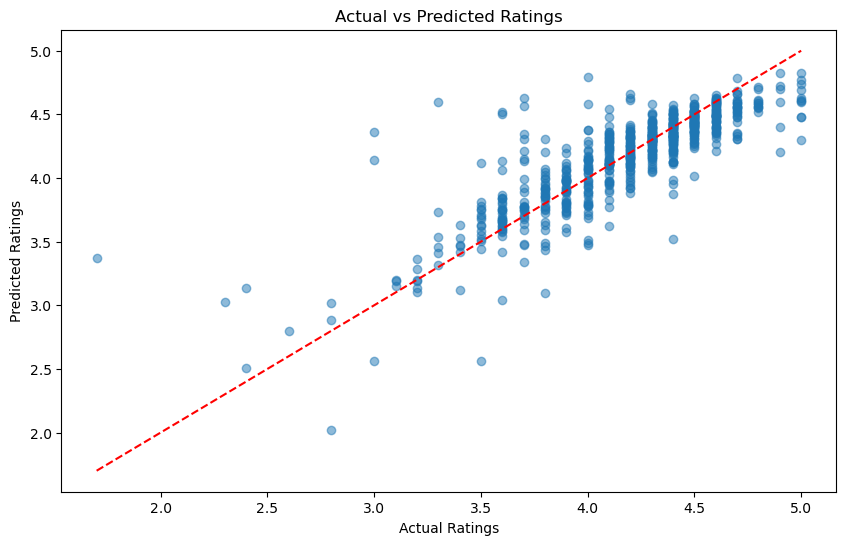

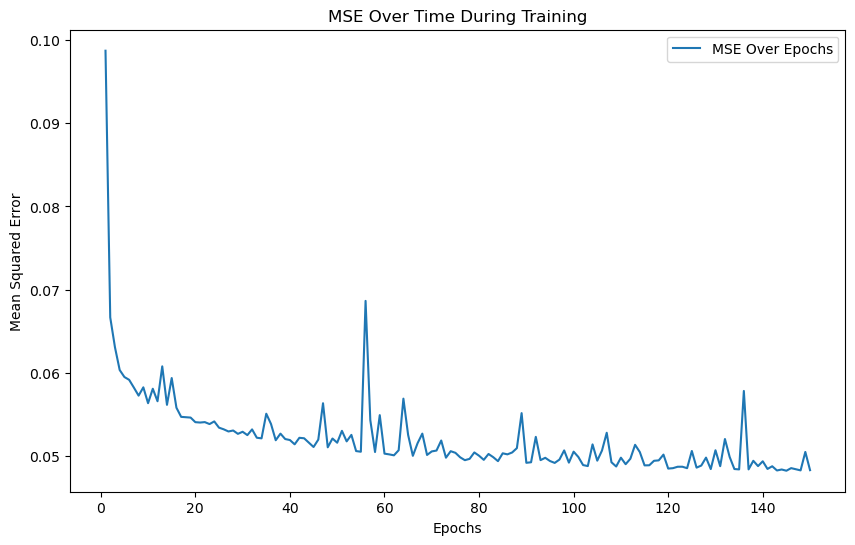

In [19]:
model = NeuralNetworkSELU(inputDim, outputDim).to(device)
model, mse_history = train_model(model, train_loader, learningRate, epochs, lambda1, lambda2)
all_predictions, all_labels, all_inputs = test_model(model, test_loader)

# Calculate metrics
mse = mean_squared_error(all_labels, all_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(all_labels, all_predictions)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

# Residual Plot
plt.figure(figsize=(10, 6))
residuals = all_labels - all_predictions
plt.scatter(all_predictions, residuals)
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Comparison Plot
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_predictions, alpha=0.5)
plt.title('Actual vs Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], 'r--')  # line representing perfect predictions
plt.show()

# Plotting the MSE over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), mse_history, label='MSE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('MSE Over Time During Training')
plt.legend()
plt.show()